In [1]:
initial_investment = 1000000
yearly_sale_percentage = 0.04
capital_gains_tax = 0.26
dividend_tax = 0.26
monthly_sale_percentage = yearly_sale_percentage / 12

In [2]:
import pandas as pd

def load_source_data(prices_file, bigmac_file):
    # Stock prices
    ts = pd.read_csv(prices_file)
    ts = ts.sort_values(by="timestamp")
    ts = ts.reset_index()
    ts = ts.drop(columns="index")
    df = pd.DataFrame({
    "timestamp": ts["timestamp"],
    "price": ts["adjusted close"],
    "dividend": ts["dividend amount"],
    })
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Big Mac index
    bigmac_pricedata = pd.read_csv(bigmac_file)
    country = "United States"
    bmprice = bigmac_pricedata[bigmac_pricedata.name == country][['date', 'dollar_price']]
    bmprice['date'] = pd.to_datetime(bmprice['date'])
    bmprice.rename(columns={"date": "timestamp", "dollar_price": "cpi"}, inplace=True)
    
    # Discard data that is not in the same time range for both datasets
    bmprice = bmprice[(bmprice['timestamp'] >= df['timestamp'].iloc[0]) & (bmprice['timestamp'] <= df['timestamp'].iloc[-1])]
    df = df[(df['timestamp'] >= bmprice['timestamp'].iloc[0]) & (df['timestamp'] <= bmprice['timestamp'].iloc[-1])]
    
    # Merge datasets
    df = pd.merge_asof(df, bmprice, on="timestamp")
    # Dividend per dollar
    df['dividend yield'] = df['dividend'] / df['price']
    # Normalize CPI to 1 and stock price to 100
    df['cpi'] = df['cpi'].fillna(bmprice['cpi'].iloc[0])
    df['cpi'] = df['cpi'] / df['cpi'].iloc[0]
    df['price'] = (df['price'] / df['price'].iloc[0] * 100).round(3)
    # Dividend per share
    df['dividend'] = (df['dividend yield'] * df['price']).round(3)
    return df

In [3]:
src = load_source_data("monthly_adjusted_VTI.csv", "bigmac.csv")
src

,timestamp,price,dividend,cpi,dividend yield
0,2002-04-30,100.000,0.000,1.000000,0.000000
1,2002-05-31,98.570,0.000,1.000000,0.000000
2,2002-06-28,91.774,0.763,1.000000,0.008312
3,2002-07-31,84.120,0.000,1.000000,0.000000
4,2002-08-30,84.763,0.000,1.000000,0.000000
...,...,...,...,...,...
238,2022-02-28,628.439,0.000,2.144681,0.000000
239,2022-03-31,648.955,2.078,2.144681,0.003202
240,2022-04-29,589.694,0.000,2.144681,0.000000
241,2022-05-31,588.212,0.000,2.144681,0.000000


In [4]:
df = src.copy()
initial_shares = initial_investment / df['price'].iloc[0]
initial_price = df['price'].iloc[0]
initial_price, initial_shares
df['shares'] = initial_shares
df['perc. sold'] = monthly_sale_percentage
df['net dividend yield'] = df['dividend yield'] * (1 - dividend_tax)
df['shares'] = (df['shares'] * (1 - (df['perc. sold'] - df['net dividend yield'])).cumprod()).round(2)
df['shares sold'] = (df['shares'].shift(1).fillna(initial_shares) * df['perc. sold']).round(2)
df['portfolio value'] = (df['shares'] * df['price']).round(2)
df['total port change'] = ((df['portfolio value'] / initial_investment)).round(4)
df['monthly value inc'] = (df['portfolio value'] - df['portfolio value'].shift(1).fillna(initial_investment)).round(2)
df['inflation adj. value'] = (df['portfolio value'] / df['cpi']).round(2)
df['infl. adj. port change'] = ((df['portfolio value'] / df['cpi'] / initial_investment)).round(4)
df['shares sold value'] = (df['shares sold'] * df['price']).round(2)
df['capital gains'] = ((df['price'] - initial_price) * df['shares sold']).round(2)
df['capital gains tax'] = (df['capital gains'] * capital_gains_tax).round(2)
df['tax %'] = (df['capital gains tax'] / df['shares sold value']).round(4)
df['net income'] = (df['shares sold'] * df['price'] - df['capital gains tax']).round(2)
df['dividend tax'] = (df['shares'] * df['dividend'] * dividend_tax).round(2)
df['infl. adj. income'] = (df['net income'] / df['cpi']).round(2)
df['infl. adj. income change'] = ((df['infl. adj. income'] / df['infl. adj. income'].iloc[0])).round(4)
df

,timestamp,price,dividend,cpi,dividend yield,shares,perc. sold,net dividend yield,shares sold,portfolio value,...,inflation adj. value,infl. adj. port change,shares sold value,capital gains,capital gains tax,tax %,net income,dividend tax,infl. adj. income,infl. adj. income change
0,2002-04-30,100.000,0.000,1.000000,0.000000,9966.67,0.003333,0.000000,33.33,996667.00,...,996667.00,0.9967,3333.00,0.00,0.00,0.0000,3333.00,0.00,3333.00,1.0000
1,2002-05-31,98.570,0.000,1.000000,0.000000,9933.44,0.003333,0.000000,33.22,979139.18,...,979139.18,0.9791,3274.50,-47.50,-12.35,-0.0038,3286.85,0.00,3286.85,0.9862
2,2002-06-28,91.774,0.763,1.000000,0.008312,9961.44,0.003333,0.006151,33.11,914201.19,...,914201.19,0.9142,3038.64,-272.36,-70.81,-0.0233,3109.45,1976.15,3109.45,0.9329
3,2002-07-31,84.120,0.000,1.000000,0.000000,9928.23,0.003333,0.000000,33.20,835162.71,...,835162.71,0.8352,2792.78,-527.22,-137.08,-0.0491,2929.86,0.00,2929.86,0.8790
4,2002-08-30,84.763,0.000,1.000000,0.000000,9895.14,0.003333,0.000000,33.09,838741.75,...,838741.75,0.8387,2804.81,-504.19,-131.09,-0.0467,2935.90,0.00,2935.90,0.8809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,2022-02-28,628.439,0.000,2.144681,0.000000,6994.96,0.003333,0.000000,23.39,4395905.67,...,2049678.24,2.0497,14699.19,12360.19,3213.65,0.2186,11485.54,0.00,5355.36,1.6068
239,2022-03-31,648.955,2.078,2.144681,0.003202,6988.22,0.003333,0.002369,23.32,4535040.31,...,2114552.53,2.1146,15133.63,12801.63,3328.42,0.2199,11805.21,3775.60,5504.41,1.6515
240,2022-04-29,589.694,0.000,2.144681,0.000000,6964.93,0.003333,0.000000,23.29,4107177.43,...,1915052.97,1.9151,13733.97,11404.97,2965.29,0.2159,10768.68,0.00,5021.11,1.5065
241,2022-05-31,588.212,0.000,2.144681,0.000000,6941.71,0.003333,0.000000,23.22,4083197.12,...,1903871.67,1.9039,13658.28,11336.28,2947.43,0.2158,10710.85,0.00,4994.15,1.4984


In [5]:
dfs = [df[i:i+12] for i in range(0, df.shape[0], 12)]

In [6]:
dfs = [df for df in dfs if df.shape[0] == 12]

In [7]:
yearly = pd.DataFrame({
    "timestamp": [d["timestamp"].iloc[-1] for d in dfs],
    "price": [d["price"].iloc[-1] for d in dfs],
    "cpi": [d["cpi"].iloc[-1] for d in dfs],
    "shares": [d["shares"].iloc[-1] for d in dfs],
    "shares sold": [d["shares sold"].sum() for d in dfs],
    "portfolio value": [d["portfolio value"].iloc[-1] for d in dfs],
    "total port change": [d["total port change"].iloc[-1] for d in dfs],
    "inflation adj. value": [d["inflation adj. value"].iloc[-1] for d in dfs],
    "infl. adj. port change": [d["infl. adj. port change"].iloc[-1] for d in dfs],
    "capital gains tax": [d["capital gains tax"].sum() for d in dfs],
    "dividend tax": [d["dividend tax"].sum() for d in dfs],
    "net income": [d["net income"].sum() for d in dfs],
    "infl. adj. income": [d["infl. adj. income"].sum() for d in dfs],
    "infl. adj. monthly income": [d["infl. adj. income"].mean() for d in dfs],
})  
yearly

,timestamp,price,cpi,shares,shares sold,portfolio value,total port change,inflation adj. value,infl. adj. port change,capital gains tax,dividend tax,net income,infl. adj. income,infl. adj. monthly income
0,2003-03-31,79.498,1.000000,9931.45,397.24,789530.41,0.7895,789530.41,0.7895,-1503.43,9499.22,35445.01,35445.01,2953.750833
1,2004-03-31,110.978,1.046809,9836.11,394.47,1091591.82,1.0916,1042780.80,1.0428,51.87,10782.65,39594.68,37824.20,3152.016667
2,2005-03-31,118.714,1.051064,9805.41,391.26,1164039.44,1.1640,1107486.92,1.1075,1417.63,14893.47,43160.70,41077.30,3423.108333
3,2006-03-31,136.407,1.136170,9771.50,390.17,1332901.00,1.3329,1173152.57,1.1732,2723.91,16192.94,46769.68,42525.01,3543.750833
4,2007-03-30,151.481,1.229787,9731.81,388.83,1474184.31,1.4742,1198731.19,1.1987,4285.30,17743.44,51079.59,42893.08,3574.423333
5,2008-03-31,142.828,1.276596,9695.35,387.08,1384767.45,1.3848,1084734.50,1.0847,5652.14,19290.73,54794.87,43202.22,3600.185000
6,2009-03-31,88.427,1.365957,9540.83,383.80,843666.97,0.8437,617637.81,0.6176,1816.50,8940.94,43550.04,32338.70,2694.891667
7,2010-03-31,135.802,1.459574,9341.75,377.42,1268628.33,1.2686,869176.84,0.8692,1721.38,7646.99,42641.34,29667.50,2472.291667
8,2011-03-31,159.659,1.502128,9142.61,369.57,1459699.97,1.4597,971754.94,0.9718,3800.02,8400.83,47772.46,32022.70,2668.558333
9,2012-03-30,171.205,1.621277,8941.71,361.45,1530865.46,1.5309,944234.60,0.9442,5276.71,8650.31,51163.27,32915.24,2742.936667


In [8]:
yearly['infl. adj. monthly income'] = yearly['infl. adj. monthly income'].round(2)
yearly['infl. adj. monthly income change'] = (yearly['infl. adj. monthly income'] / yearly['infl. adj. monthly income'].shift(1)).round(4)

In [9]:
yearly

,timestamp,price,cpi,shares,shares sold,portfolio value,total port change,inflation adj. value,infl. adj. port change,capital gains tax,dividend tax,net income,infl. adj. income,infl. adj. monthly income,infl. adj. monthly income change
0,2003-03-31,79.498,1.000000,9931.45,397.24,789530.41,0.7895,789530.41,0.7895,-1503.43,9499.22,35445.01,35445.01,2953.75,NaN
1,2004-03-31,110.978,1.046809,9836.11,394.47,1091591.82,1.0916,1042780.80,1.0428,51.87,10782.65,39594.68,37824.20,3152.02,1.0671
2,2005-03-31,118.714,1.051064,9805.41,391.26,1164039.44,1.1640,1107486.92,1.1075,1417.63,14893.47,43160.70,41077.30,3423.11,1.0860
3,2006-03-31,136.407,1.136170,9771.50,390.17,1332901.00,1.3329,1173152.57,1.1732,2723.91,16192.94,46769.68,42525.01,3543.75,1.0352
4,2007-03-30,151.481,1.229787,9731.81,388.83,1474184.31,1.4742,1198731.19,1.1987,4285.30,17743.44,51079.59,42893.08,3574.42,1.0087
5,2008-03-31,142.828,1.276596,9695.35,387.08,1384767.45,1.3848,1084734.50,1.0847,5652.14,19290.73,54794.87,43202.22,3600.18,1.0072
6,2009-03-31,88.427,1.365957,9540.83,383.80,843666.97,0.8437,617637.81,0.6176,1816.50,8940.94,43550.04,32338.70,2694.89,0.7485
7,2010-03-31,135.802,1.459574,9341.75,377.42,1268628.33,1.2686,869176.84,0.8692,1721.38,7646.99,42641.34,29667.50,2472.29,0.9174
8,2011-03-31,159.659,1.502128,9142.61,369.57,1459699.97,1.4597,971754.94,0.9718,3800.02,8400.83,47772.46,32022.70,2668.56,1.0794
9,2012-03-30,171.205,1.621277,8941.71,361.45,1530865.46,1.5309,944234.60,0.9442,5276.71,8650.31,51163.27,32915.24,2742.94,1.0279


In [10]:
yearly['infl. adj. monthly income total change'] = (yearly['infl. adj. monthly income'] / yearly['infl. adj. monthly income'].iloc[0]).round(4)

In [11]:
yearly

,timestamp,price,cpi,shares,shares sold,portfolio value,total port change,inflation adj. value,infl. adj. port change,capital gains tax,dividend tax,net income,infl. adj. income,infl. adj. monthly income,infl. adj. monthly income change,infl. adj. monthly income total change
0,2003-03-31,79.498,1.000000,9931.45,397.24,789530.41,0.7895,789530.41,0.7895,-1503.43,9499.22,35445.01,35445.01,2953.75,NaN,1.0000
1,2004-03-31,110.978,1.046809,9836.11,394.47,1091591.82,1.0916,1042780.80,1.0428,51.87,10782.65,39594.68,37824.20,3152.02,1.0671,1.0671
2,2005-03-31,118.714,1.051064,9805.41,391.26,1164039.44,1.1640,1107486.92,1.1075,1417.63,14893.47,43160.70,41077.30,3423.11,1.0860,1.1589
3,2006-03-31,136.407,1.136170,9771.50,390.17,1332901.00,1.3329,1173152.57,1.1732,2723.91,16192.94,46769.68,42525.01,3543.75,1.0352,1.1997
4,2007-03-30,151.481,1.229787,9731.81,388.83,1474184.31,1.4742,1198731.19,1.1987,4285.30,17743.44,51079.59,42893.08,3574.42,1.0087,1.2101
5,2008-03-31,142.828,1.276596,9695.35,387.08,1384767.45,1.3848,1084734.50,1.0847,5652.14,19290.73,54794.87,43202.22,3600.18,1.0072,1.2189
6,2009-03-31,88.427,1.365957,9540.83,383.80,843666.97,0.8437,617637.81,0.6176,1816.50,8940.94,43550.04,32338.70,2694.89,0.7485,0.9124
7,2010-03-31,135.802,1.459574,9341.75,377.42,1268628.33,1.2686,869176.84,0.8692,1721.38,7646.99,42641.34,29667.50,2472.29,0.9174,0.8370
8,2011-03-31,159.659,1.502128,9142.61,369.57,1459699.97,1.4597,971754.94,0.9718,3800.02,8400.83,47772.46,32022.70,2668.56,1.0794,0.9034
9,2012-03-30,171.205,1.621277,8941.71,361.45,1530865.46,1.5309,944234.60,0.9442,5276.71,8650.31,51163.27,32915.24,2742.94,1.0279,0.9286


Text(0.5, 1.0, 'Portfolio value')

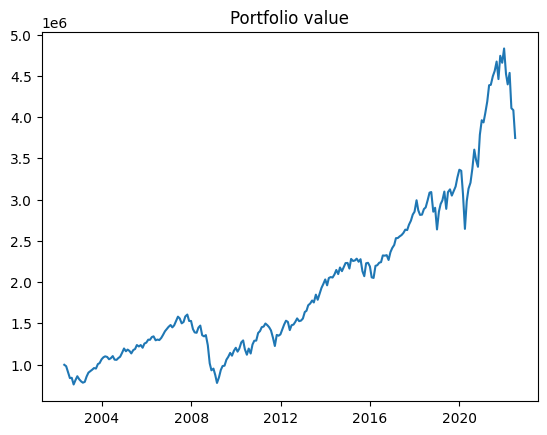

In [12]:
# plot portfolio value
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

fig, ax = plt.subplots()
ax.plot(df['timestamp'], df['portfolio value'])
ax.set_title('Portfolio value')

Text(0.5, 1.0, 'Stock price')

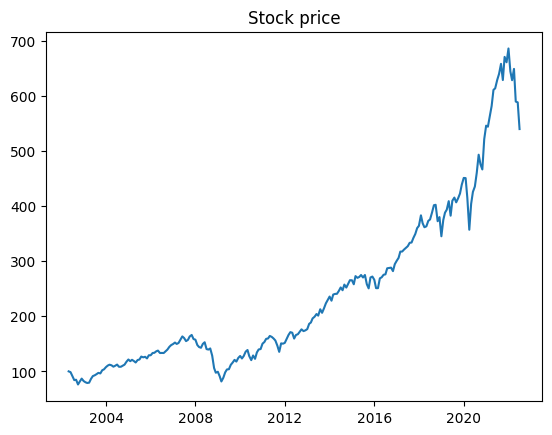

In [13]:
fig, ax = plt.subplots()
ax.plot(df['timestamp'], df['price'])
ax.set_title('Stock price')

Text(0.5, 1.0, 'Big Mac CPI')

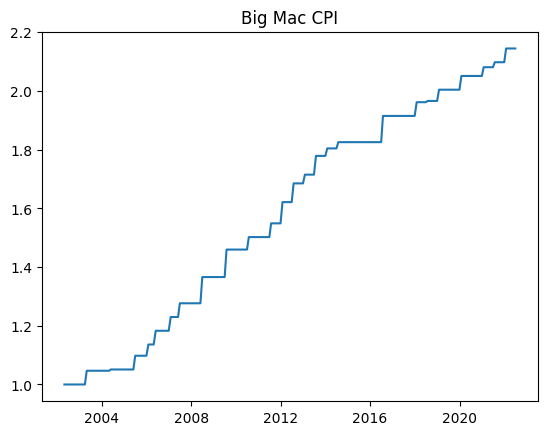

In [14]:
fig, ax = plt.subplots()
ax.plot(df['timestamp'], df['cpi'])
ax.set_title('Big Mac CPI')

Text(0.5, 1.0, 'Inflation adjusted monthly income')

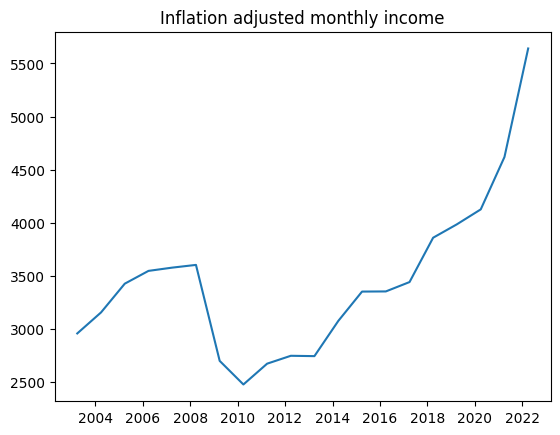

In [18]:
fig, ax = plt.subplots()
ax.plot(yearly['timestamp'], yearly['infl. adj. monthly income'])
ax.set_title('Inflation adjusted monthly income')

Text(0.5, 1.0, 'Inflation adjusted portfolio value')

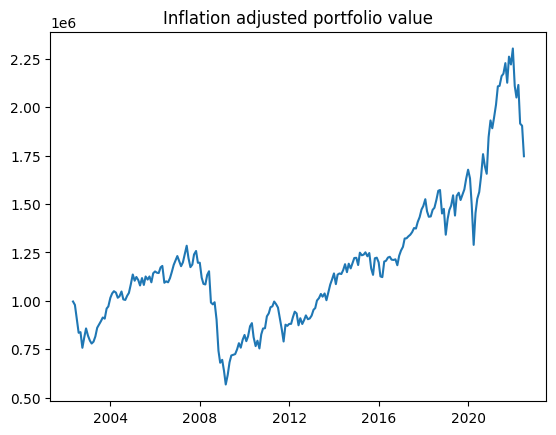

In [17]:
fig, ax = plt.subplots()
ax.plot(df['timestamp'], df['inflation adj. value'])
ax.set_title('Inflation adjusted portfolio value')